In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [98]:
df = pd.read_csv("C:/Defi_IA/data/Dataset/weather.csv")
df.sort_values(['test', 'station', 'day'], inplace=True)
#df.columns = ['station', 'y', 'test', 'month', 'day', 'latitude', 'longitude', 'height', 'ff', 't', 'td', 'hu', 'dd', 'precip']
df.interpolate(inplace=True)
df["id"] = df["station"].astype(str) + "_" + df["day_index"].astype(str)
df = df.set_index("id")
df.drop(['latitude', 'longitude', 'month', 'day_index'], axis=1, inplace=True)
df.head()

,station,y,test,height,day,mean_ff,mean_t,mean_td,mean_hu,mean_dd,mean_precip
id,,,,,,,,,,,
14066001_0,14066001,3.4,False,2.0,0,3.641875,279.904167,278.099167,88.858333,176.625000,0.008333
14066001_1,14066001,11.7,False,2.0,1,5.291458,287.411042,284.046042,80.875000,235.041667,0.070833
14066001_2,14066001,0.6,False,2.0,2,5.321875,283.175833,280.189792,82.381250,191.104167,0.356250
14066001_3,14066001,0.4,False,2.0,3,5.271875,285.037917,282.109167,82.545833,223.583333,0.012500
14066001_4,14066001,3.0,False,2.0,4,4.204583,286.464375,283.707083,83.589583,187.729167,0.008333


In [43]:
station_count = df[df.test==True].value_counts('station')

In [60]:
df[df.test==False].precip.isnull().mean()

0.05434102325480144

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

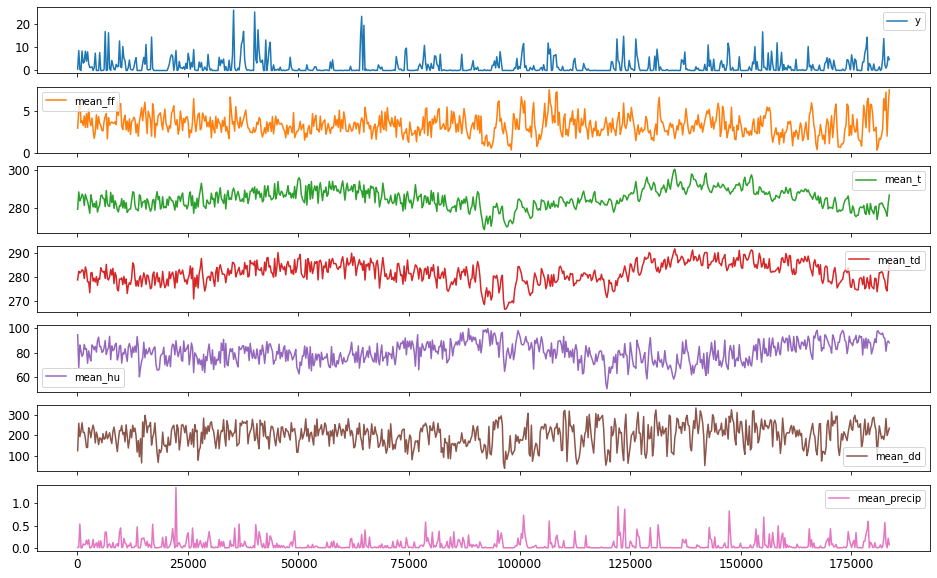

In [74]:
#14066001
#14126001
df[(df.station==35281001) & (df.test==False)].iloc[:730][['y', 'mean_ff', 'mean_t', 'mean_td', 'mean_hu', 'mean_dd', 'mean_precip']].plot(subplots=True, fontsize=12, figsize=(16,10))

In [86]:
# The "test" column is a boolean column which is equal to True for test and False for train.
X_train = df[df["test"] == False].copy()
X_test = df[df["test"]].copy()

X_train = X_train[X_train["y"].notnull()]

# y_train is the target variable to train our model.
y_train = X_train["y"].astype(float).copy()

X_test["id"] = X_test["station"].astype(str) + "_" + X_test["day_index"].astype(str)
X_test = X_test.set_index("id")

columns_to_drop = ["y", "test", "station", "day", "day_index"]

X_train = X_train.drop(columns_to_drop, axis = "columns")
X_test = X_test.drop(columns_to_drop, axis = "columns")

X_train[X_train.columns] = MinMaxScaler().fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = MinMaxScaler().fit_transform(X_test[X_test.columns])

In [87]:
X_train.head()

,month,height,mean_ff,mean_t,mean_td,mean_hu,mean_dd,mean_precip
0,0.0,0.0,0.182703,0.424323,0.686315,0.887458,0.496661,0.002717
249,0.0,0.0,0.265458,0.572361,0.763984,0.806818,0.660926,0.023098
499,0.0,0.0,0.266984,0.488841,0.713620,0.822033,0.537376,0.116168
749,0.0,0.0,0.264475,0.525562,0.738688,0.823695,0.628705,0.004076
997,0.0,0.0,0.210932,0.553692,0.759557,0.834238,0.527885,0.002717


In [6]:
df_train = df[df.test==False].fillna(-1)
set(df_train.columns) - set(["station", "y", "day", "test"])

{'height',
 'latitude',
 'longitude',
 'mean_dd_by_station_day',
 'mean_ff_by_station_day',
 'mean_hu_by_station_day',
 'mean_precip_by_station_day',
 'mean_t_by_station_day',
 'mean_td_by_station_day',
 'month'}

In [7]:
def prepare_sequences(x_train, y_train, window_length):
    windows = []
    windows_y = []
    for i, sequence in enumerate(x_train):
        len_seq = len(sequence)
        for window_start in range(0, len_seq - window_length + 1):
            window_end = window_start + window_length
            window = sequence[window_start:window_end]
            windows.append(window)
            windows_y.append(y_train[i])
    return np.array(windows), np.array(windows_y)

In [96]:


#y_train = df_train.y.astype(float).copy()
#columns_to_drop = ["y", "test"]
#X_train = df_train.drop(columns_to_drop, axis = "columns")



#X_train = np.array(list(X_train.groupby('station').apply(lambda x: np.array(x[features_names]))))
#y_train = np.array(list(df_train.groupby('station').y.apply(np.array)))

#X_train = np.asarray(X_train).astype('float32')
#y_train = np.asarray(y_train).astype('float32')

In [122]:
from keras.preprocessing.sequence import TimeseriesGenerator

df_train = df[df.test==False].fillna(-1)
features_names = list(set(df_train.columns) - set(["station", "y", "day", "test"]))

df_train[features_names] =  MinMaxScaler().fit_transform(df_train[features_names])
df_train.y =  MinMaxScaler().fit_transform(df_train[['y']])

nb_day_station = df_train.station.value_counts()
df_train = df_train[df_train.station.isin(nb_day_station[nb_day_station == 730].index)]

def preprocess_data(df):
    X_train, y_train = [], []
    for _, group in df.groupby('station'):
        data_gen = TimeseriesGenerator(group[features_names].to_numpy(), group.y.to_numpy(), length=16, sampling_rate=1, batch_size=1)
        X_train += [x[0] for x in data_gen]
        y_train += [x[1] for x in data_gen]
    return np.concatenate(X_train, axis=0), np.concatenate(y_train, axis=0)

X_train, y_train = preprocess_data(df_train[df_train.day <= 600])
X_val, y_val = preprocess_data(df_train[df_train.day > 600])

In [106]:
df_train

,station,y,test,height,day,mean_ff,mean_t,mean_td,mean_hu,mean_dd,mean_precip
id,,,,,,,,,,,
14066001_0,14066001,0.036364,False,0.000000,0,0.182703,0.424323,0.686315,0.887458,0.496661,0.002717
14066001_1,14066001,0.125134,False,0.000000,1,0.265458,0.572361,0.763984,0.806818,0.660926,0.023098
14066001_2,14066001,0.006417,False,0.000000,2,0.266984,0.488841,0.713620,0.822033,0.537376,0.116168
14066001_3,14066001,0.004278,False,0.000000,3,0.264475,0.525562,0.738688,0.823695,0.628705,0.004076
14066001_4,14066001,0.032086,False,0.000000,4,0.210932,0.553692,0.759557,0.834238,0.527885,0.002717
...,...,...,...,...,...,...,...,...,...,...,...
91200002_725,91200002,0.023529,False,0.341317,725,0.177696,0.374371,0.655083,0.889808,0.645870,0.013043
91200002_726,91200002,0.000000,False,0.341317,726,0.231741,0.371279,0.642182,0.838068,0.777153,0.026087
91200002_727,91200002,0.078075,False,0.341317,727,0.082086,0.313001,0.615664,0.895960,0.603398,0.000000


In [110]:
print(X_train.shape)
print(y_train.shape)

(138762, 8, 7)
(138762,)


In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

def lstm_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=X_train.shape[1:], activation='relu', return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(LSTM(64, activation='relu'))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='mse', optimizer='adam', metrics='mean_absolute_percentage_error')
    
    return model

lstm_model().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 16, 64)            18432     
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 53,569
Trainable params: 53,569
Non-trainable params: 0
_________________________________________________________________


In [124]:
model = lstm_model()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
2139/2139 [==============================] - 37s 17ms/step - loss: 0.0035 - mean_absolute_percentage_error: 1358855.6250 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 74.5821
Epoch 2/10
2139/2139 [==============================] - 45s 21ms/step - loss: 0.0022 - mean_absolute_percentage_error: 56.9779 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 74.5821
Epoch 3/10
2139/2139 [==============================] - 46s 21ms/step - loss: 0.0022 - mean_absolute_percentage_error: 56.9779 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 74.5821
Epoch 4/10
2139/2139 [==============================] - 46s 22ms/step - loss: 0.0022 - mean_absolute_percentage_error: 56.9779 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 74.5821
Epoch 5/10
1149/2139 [===============>..............] - ETA: 20s - loss: 0.0022 - mean_absolute_percentage_error: 57.0143

In [121]:
# The "test" column is a boolean column which is equal to True for test and False for train.
X_train_class = df[df["test"] == False].copy()
X_test_class = df[df["test"]].copy()

X_train_class = X_train_class[X_train_class["y"].notnull()]

# y_train is the target variable to train our model.
y_train_class = X_train_class["y"].astype(float).copy()

columns_to_drop = ["station", "y", "test"]

X_train_class = X_train_class.drop(columns_to_drop, axis = "columns")
X_test_class = X_test_class.drop(columns_to_drop, axis = "columns")

from sklearn.preprocessing import MinMaxScaler
X_train_class[X_train_class.columns] = MinMaxScaler().fit_transform(X_train_class)
X_test_class[X_test_class.columns] = MinMaxScaler().fit_transform(X_test_class)

X_train_class.head()

,height,day,mean_ff,mean_t,mean_td,mean_hu,mean_dd,mean_precip
id,,,,,,,,
14066001_0,0.0,0.000000,0.182703,0.424323,0.686315,0.887458,0.496661,0.002717
14066001_1,0.0,0.001372,0.265458,0.572361,0.763984,0.806818,0.660926,0.023098
14066001_2,0.0,0.002743,0.266984,0.488841,0.713620,0.822033,0.537376,0.116168
14066001_3,0.0,0.004115,0.264475,0.525562,0.738688,0.823695,0.628705,0.004076
14066001_4,0.0,0.005487,0.210932,0.553692,0.759557,0.834238,0.527885,0.002717


In [117]:
import lightgbm as lgbm

from sklearn import model_selection
from sklearn import metrics

#  Fold:
k = 5

cv = model_selection.KFold(k, shuffle=True, random_state=42)

model = lgbm.LGBMRegressor(
    n_estimators=600, # Number of trees
    objective="l2",
    random_state=42,
)

error_validation = 0

sub = pd.Series(0.0, index=X_test.index)

for fit_idx, val_idx in cv.split(X_train_class, y_train_class):
    X_fit = X_train_class.iloc[fit_idx]
    X_val = X_train_class.iloc[val_idx]
    
    y_fit = y_train_class.iloc[fit_idx] 
    y_val = y_train_class.iloc[val_idx]

    model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=("fit", "val"),
        eval_metric="l2",
        early_stopping_rounds = 200,
        feature_name=X_fit.columns.tolist(),
        verbose=50,
    )
    
    # Validation predictions:
    error_validation += metrics.mean_absolute_percentage_error(
        y_true = model.predict(X_val) + 1, 
        y_pred = y_val + 1,
    ) / k
    
    # Bagging
    # Since we train 5 models using cross-validation with k=5 folds, we average the prediction of each models.
    # It helps a lot!
    sub += model.predict(X_test) / k
    
# To avoid zero-division errors, METEO FRANCE added 1 to the target variable, so we do it too.
sub += 1

print(f"MAPE on validation set: {error_validation}")

C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 12.0261	val's l2: 12.1371
[100]	fit's l2: 10.7364	val's l2: 11.1182
[150]	fit's l2: 9.98824	val's l2: 10.5966
[200]	fit's l2: 9.43847	val's l2: 10.2382
[250]	fit's l2: 9.01044	val's l2: 9.99152
[300]	fit's l2: 8.68758	val's l2: 9.8397
[350]	fit's l2: 8.39929	val's l2: 9.71998
[400]	fit's l2: 8.17741	val's l2: 9.6345
[450]	fit's l2: 7.96293	val's l2: 9.54918
[500]	fit's l2: 7.76503	val's l2: 9.48261
[550]	fit's l2: 7.56437	val's l2: 9.41189
[600]	fit's l2: 7.3925	val's l2: 9.36571


C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 11.9213	val's l2: 12.1069
[100]	fit's l2: 10.5089	val's l2: 10.9992
[150]	fit's l2: 9.76158	val's l2: 10.4806
[200]	fit's l2: 9.21839	val's l2: 10.1744
[250]	fit's l2: 8.80636	val's l2: 9.95567
[300]	fit's l2: 8.50214	val's l2: 9.83401
[350]	fit's l2: 8.21753	val's l2: 9.7162
[400]	fit's l2: 7.99625	val's l2: 9.63311
[450]	fit's l2: 7.78318	val's l2: 9.54094
[500]	fit's l2: 7.58457	val's l2: 9.46837
[550]	fit's l2: 7.40244	val's l2: 9.41391
[600]	fit's l2: 7.23956	val's l2: 9.37132


C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 11.5698	val's l2: 12.4179
[100]	fit's l2: 10.3047	val's l2: 11.3911
[150]	fit's l2: 9.61094	val's l2: 10.8905
[200]	fit's l2: 9.08411	val's l2: 10.5448
[250]	fit's l2: 8.65873	val's l2: 10.2878
[300]	fit's l2: 8.32179	val's l2: 10.1133
[350]	fit's l2: 8.07543	val's l2: 10.0039
[400]	fit's l2: 7.83359	val's l2: 9.91736
[450]	fit's l2: 7.59734	val's l2: 9.82317
[500]	fit's l2: 7.40517	val's l2: 9.76113
[550]	fit's l2: 7.22482	val's l2: 9.69564
[600]	fit's l2: 7.07301	val's l2: 9.66928


C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 11.7803	val's l2: 12.2698
[100]	fit's l2: 10.5775	val's l2: 11.316
[150]	fit's l2: 9.85607	val's l2: 10.8241
[200]	fit's l2: 9.29275	val's l2: 10.482
[250]	fit's l2: 8.90163	val's l2: 10.2841
[300]	fit's l2: 8.57247	val's l2: 10.1242
[350]	fit's l2: 8.27185	val's l2: 9.97331
[400]	fit's l2: 8.02942	val's l2: 9.86309
[450]	fit's l2: 7.79626	val's l2: 9.76568
[500]	fit's l2: 7.61211	val's l2: 9.72071
[550]	fit's l2: 7.42012	val's l2: 9.67237
[600]	fit's l2: 7.25941	val's l2: 9.62119


C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 11.8765	val's l2: 12.0056
[100]	fit's l2: 10.6282	val's l2: 11.0728
[150]	fit's l2: 9.8861	val's l2: 10.5826
[200]	fit's l2: 9.32784	val's l2: 10.2561
[250]	fit's l2: 8.91625	val's l2: 10.0468
[300]	fit's l2: 8.55129	val's l2: 9.87379
[350]	fit's l2: 8.25656	val's l2: 9.76978
[400]	fit's l2: 8.01402	val's l2: 9.70278
[450]	fit's l2: 7.80076	val's l2: 9.63943
[500]	fit's l2: 7.57806	val's l2: 9.56639
[550]	fit's l2: 7.40217	val's l2: 9.51999
[600]	fit's l2: 7.227	val's l2: 9.48604


In [119]:
print(f"MAPE on validation set: {error_validation*100}")

MAPE on validation set: 47.95949272769459
